In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from typing import Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, cross_validate


# read data
in_kaggle = False


def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/tabular-playground-series-jan-2021/train.csv'
        test_path = '../input/tabular-playground-series-jan-2021/test.csv'
        sample_submission_path = '../input/tabular-playground-series-jan-2021/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/test.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

Started at  2021-01-29 16:20:41.814336


In [3]:
%%time
# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

df_train = pd.read_csv(train_set_path)
df_test = pd.read_csv(test_set_path)

subm = pd.read_csv(sample_subm_path)

Wall time: 1.26 s


In [4]:
df_train.head()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


In [5]:
%%time
# list of basic raw features
feature_list = [col for col in df_train.columns if col.startswith('cont')]

# Additional feature engineering routines

# add additional features pre-selected in the previous featurewiz feature importance experiments
def add_extra_features(
    train: pd.DataFrame, 
    test: pd.DataFrame) -> [pd.DataFrame, pd.DataFrame]:
    
    small_val = 0.00001
    for df in [train, test]:
        df['c_std'] = df[feature_list].std(axis=1)
        df['c_kurt'] = df[feature_list].kurtosis(axis=1)
        df['cont2_squared'] = df['cont2'] ** 2
        df['cont3_squared'] = df['cont3'] ** 2
        df['cont9_squared'] = df['cont9'] ** 2
        df['cont12_squared'] = df['cont12'] ** 2
        df['cont14_squared'] = df['cont14'] ** 2
        df['cont7_squared'] = df['cont7'] ** 2
        df['cont13_squared'] = df['cont13'] ** 2
        df['cont8_squared'] = df['cont8'] ** 2
        df['cont11_plus_cont3'] = df['cont11'] + df['cont3']
        df['cont13_plus_cont3'] = df['cont13'] + df['cont3']
        df['cont1_plus_cont4'] = df['cont1'] + df['cont4']
        df['cont5_plus_cont11'] = df['cont5'] + df['cont11']
        df['cont3_plus_cont8'] = df['cont3'] + df['cont8']
        df['cont3_plus_cont14'] = df['cont3'] + df['cont14']
        df['cont4_plus_cont3'] = df['cont4'] + df['cont3']
        df['cont4_plus_cont2'] = df['cont4'] + df['cont2']
        df['cont14_plus_cont11'] = df['cont14'] + df['cont11']
        df['cont14_plus_cont4'] = df['cont14'] + df['cont4']
        df['cont10_minus_cont12'] = df['cont10'] - df['cont12']
        df['cont13_minus_cont2'] = df['cont13'] - df['cont2']
        df['cont11_minus_cont10'] = df['cont11'] - df['cont10']
        df['cont4_minus_cont11'] = df['cont4'] - df['cont11']
        df['cont1_minus_cont6'] = df['cont1'] - df['cont6']
        df['cont5_minus_cont4'] = df['cont5'] - df['cont4']
        df['cont13_minus_cont10'] = df['cont13'] - df['cont10']
        df['cont13_minus_cont6'] = df['cont13'] - df['cont6']
        df['cont10_minus_cont6'] = df['cont10'] - df['cont6']
        df['cont13_minus_cont8'] = df['cont13'] - df['cont8']
        df['cont14_minus_cont13'] = df['cont14'] - df['cont13']
        df['cont9_minus_cont13'] = df['cont9'] - df['cont13']
        df['cont7_minus_cont13'] = df['cont7'] - df['cont13']
        df['cont12_minus_cont8'] = df['cont12'] - df['cont8']
        df['cont2_minus_cont3'] = df['cont2'] - df['cont3']
        df['cont8_minus_cont4'] = df['cont8'] - df['cont4']
        df['cont12_minus_cont6'] = df['cont12'] - df['cont6']
        df['cont5_minus_cont2'] = df['cont5'] - df['cont12']
        df['cont14_minus_cont8'] = df['cont14'] - df['cont8']
        df['cont10_minus_cont9'] = df['cont10'] - df['cont9']
        df['cont1_minus_cont9'] = df['cont1'] - df['cont9']
        df['cont9_minus_cont12'] = df['cont9'] - df['cont12']
        df['cont6_minus_cont11'] = df['cont6'] - df['cont11']
        df['cont6_minus_cont9'] = df['cont6'] - df['cont9']
        df['cont14_minus_cont4'] = df['cont14'] - df['cont4']
        df['cont7_minus_cont11'] = df['cont7'] - df['cont11']
        df['cont1_minus_cont10'] = df['cont1'] - df['cont10']
        df['cont12_minus_cont11'] = df['cont12'] - df['cont11']
        df['cont4_prod_cont3'] = df['cont4'] * df['cont3']
        df['cont4_prod_cont2'] = df['cont4'] * df['cont2']
        df['cont11_prod_cont4'] = df['cont11'] * df['cont4']
        df['cont11_prod_cont3'] = df['cont11'] * df['cont3']
        df['cont13_prod_cont3'] = df['cont13'] * df['cont3']
        df['cont12_prod_cont5'] = df['cont12'] * df['cont5']
        df['cont14_prod_cont11'] = df['cont14'] * df['cont11']
        df['cont8_prod_cont3'] = df['cont8'] * df['cont3']
        df['cont14_prod_cont3'] = df['cont14'] * df['cont3']
        df['cont12_qq_cont10'] = (df['cont12'] + df['cont10']) * (df['cont12'] - df['cont10'])
        df['cont10_qq_cont6'] = (df['cont10'] + df['cont6']) * (df['cont10'] - df['cont6'])
        df['cont1_qq_cont6'] = (df['cont1'] + df['cont6']) * (df['cont1'] - df['cont6'])
        df['cont13_qq_cont10'] = (df['cont13'] + df['cont10']) * (df['cont13'] - df['cont10'])
        df['cont11_qq_cont13'] = (df['cont11'] + df['cont13']) * (df['cont11'] - df['cont13'])
        df['cont4_qq_cont11'] = (df['cont4'] + df['cont11']) * (df['cont4'] - df['cont11'])
        df['cont8_qq_cont10'] = (df['cont8'] + df['cont10']) * (df['cont8'] - df['cont10'])
        df['cont9_qq_cont13'] = (df['cont9'] + df['cont13']) * (df['cont9'] - df['cont13'])
        df['cont13_qq_cont2'] = (df['cont13'] + df['cont2']) * (df['cont13'] - df['cont2'])
        df['cont5_qq_cont9'] = (df['cont5'] + df['cont9']) * (df['cont5'] - df['cont9'])
        df['cont7_qq_cont2'] = (df['cont7'] + df['cont2']) * (df['cont7'] - df['cont2'])
        df['cont1_qq_cont12'] = (df['cont1'] + df['cont12']) * (df['cont1'] - df['cont12'])
        df['cont3_qq_cont11'] = (df['cont3'] + df['cont11']) * (df['cont3'] - df['cont11'])
        df['cont5_qq_cont4'] = (df['cont5'] + df['cont4']) * (df['cont5'] - df['cont4'])
        df['cont10_qq_cont9'] = (df['cont10'] + df['cont9']) * (df['cont10'] - df['cont9'])
        df['cont7_qq_cont9'] = (df['cont7'] + df['cont9']) * (df['cont7'] - df['cont9'])
        df['cont3_qq_cont2'] = (df['cont3'] + df['cont2']) * (df['cont3'] - df['cont2'])
        df['cont1_qq_cont9'] = (df['cont1'] + df['cont9']) * (df['cont1'] - df['cont9'])
        df['cont14_qq_cont8'] = (df['cont14'] + df['cont8']) * (df['cont14'] - df['cont8'])
        df['cont8_qq_cont2'] = (df['cont8'] + df['cont2']) * (df['cont8'] - df['cont2'])
        df['cont5_qq_cont14'] = (df['cont5'] + df['cont14']) * (df['cont5'] - df['cont14'])
        df['cont6_qq_cont12'] = (df['cont6'] + df['cont12']) * (df['cont6'] - df['cont12'])
        df['cont11_qq_cont14'] = (df['cont11'] + df['cont14']) * (df['cont11'] - df['cont14'])
        df['cont12_qq_cont11'] = (df['cont12'] + df['cont11']) * (df['cont12'] - df['cont11'])
        df['cont1_qq_cont10'] = (df['cont1'] + df['cont10']) * (df['cont1'] - df['cont10'])
        df['cont4_qq_cont8'] = (df['cont4'] + df['cont8']) * (df['cont4'] - df['cont8'])
        df['cont10_div2_cont12'] = (df['cont10'] - df['cont12']) / (df['cont10'] + df['cont12'] + small_val)
        df['cont7_div2_cont1'] = (df['cont7'] - df['cont1']) / (df['cont7'] + df['cont1'] + small_val)
        df['cont10_div2_cont11'] = (df['cont10'] - df['cont11']) / (df['cont10'] + df['cont11'] + small_val)
        df['cont10_div2_cont6'] = (df['cont10'] - df['cont6']) / (df['cont10'] + df['cont6'] + small_val)
        df['cont12_div2_cont13'] = (df['cont12'] - df['cont13']) / (df['cont12'] + df['cont13'] + small_val)
        df['cont13_div2_cont8'] = (df['cont13'] - df['cont8']) / (df['cont13'] + df['cont8'] + small_val)
        df['cont9_div2_cont2'] = (df['cont9'] - df['cont2']) / (df['cont9'] + df['cont2'] + small_val)
        df['cont7_div2_cont4'] = (df['cont7'] - df['cont4']) / (df['cont7'] + df['cont4'] + small_val)
        df['cont9_div2_cont3'] = (df['cont9'] - df['cont3']) / (df['cont9'] + df['cont3'] + small_val)
        df['cont13_div2_cont1'] = (df['cont13'] - df['cont1']) / (df['cont13'] + df['cont1'] + small_val)
        df['cont10_div2_cont13'] = (df['cont10'] - df['cont13']) / (df['cont10'] + df['cont13'] + small_val)
        df['cont11_div2_cont3'] = (df['cont11'] - df['cont3']) / (df['cont11'] + df['cont3'] + small_val)
        df['cont7_div2_cont10'] = (df['cont7'] - df['cont10']) / (df['cont7'] + df['cont10'] + small_val)
        df['cont10_div2_cont1'] = (df['cont10'] - df['cont1']) / (df['cont10'] + df['cont1'] + small_val)
        df['cont8_div2_cont11'] = (df['cont8'] - df['cont11']) / (df['cont8'] + df['cont11'] + small_val)
        df['cont11_div2_cont9'] = (df['cont11'] - df['cont9']) / (df['cont11'] + df['cont9'] + small_val)
        df['cont9_div2_cont6'] = (df['cont9'] - df['cont6']) / (df['cont9'] + df['cont6'] + small_val)
        df['cont4_div2_cont14'] = (df['cont4'] - df['cont14']) / (df['cont4'] + df['cont14'] + small_val)
        df['cont4_div2_cont5'] = (df['cont4'] - df['cont5']) / (df['cont4'] + df['cont5'] + small_val)
        df['cont9_div2_cont1'] = (df['cont9'] - df['cont1']) / (df['cont9'] + df['cont1'] + small_val)
        df['cont8_div2_cont4'] = (df['cont8'] - df['cont4']) / (df['cont8'] + df['cont4'] + small_val)
        df['cont14_div2_cont5'] = (df['cont14'] - df['cont5']) / (df['cont14'] + df['cont5'] + small_val)
        df['cont9_div2_cont7'] = (df['cont9'] - df['cont7']) / (df['cont9'] + df['cont7'] + small_val)
        df['cont8_div2_cont14'] = (df['cont8'] - df['cont14']) / (df['cont8'] + df['cont14'] + small_val)
        df['cont6_div2_cont12'] = (df['cont6'] - df['cont12']) / (df['cont6'] + df['cont12'] + small_val)
        df['cont9_div2_cont8'] = (df['cont9'] - df['cont8']) / (df['cont9'] + df['cont8'] + small_val)
        df['cont6_div2_cont7'] = (df['cont6'] - df['cont7']) / (df['cont6'] + df['cont7'] + small_val)
        df['cont10_div2_cont9'] = (df['cont10'] - df['cont9']) / (df['cont10'] + df['cont9'] + small_val)
        df['cont7_div2_cont12'] = (df['cont7'] - df['cont12']) / (df['cont7'] + df['cont12'] + small_val)
        df['cont11_div2_cont12'] = (df['cont11'] - df['cont12']) / (df['cont11'] + df['cont12'] + small_val)
        df['cont11_div2_cont7'] = (df['cont11'] - df['cont7']) / (df['cont11'] + df['cont7'] + small_val)
        df['cont12_div2_cont10'] = (df['cont12'] - df['cont10']) / (df['cont12'] + df['cont10'] + small_val)
        df['cont11_div2_cont10'] = (df['cont11'] - df['cont10']) / (df['cont11'] + df['cont10'] + small_val)
        df['cont6_div2_cont10'] = (df['cont6'] - df['cont10']) / (df['cont6'] + df['cont10'] + small_val)
        df['cont8_div2_cont13'] = (df['cont8'] - df['cont13']) / (df['cont8'] + df['cont13'] + small_val)
        df['cont4_div2_cont8'] = (df['cont4'] - df['cont8']) / (df['cont4'] + df['cont8'] + small_val)
        df['cont13_div2_cont10'] = (df['cont13'] - df['cont10']) / (df['cont13'] + df['cont10'] + small_val)
        df['cont5_div2_cont4'] = (df['cont5'] - df['cont4']) / (df['cont5'] + df['cont4'] + small_val)
        df['cont10_div2_cont7'] = (df['cont10'] - df['cont7']) / (df['cont10'] + df['cont7'] + small_val)
        df['cont3_div2_cont9'] = (df['cont3'] - df['cont9']) / (df['cont3'] + df['cont9'] + small_val)
        df['cont9_div2_cont11'] = (df['cont9'] - df['cont11']) / (df['cont9'] + df['cont11'] + small_val)
        df['cont1_div2_cont9'] = (df['cont1'] - df['cont9']) / (df['cont1'] + df['cont9'] + small_val)
        df['cont3_div2_cont11'] = (df['cont3'] - df['cont11']) / (df['cont3'] + df['cont11'] + small_val)
        df['cont3_div2_cont5'] = (df['cont3'] - df['cont5']) / (df['cont3'] + df['cont5'] + small_val)
        df['cont14_div2_cont8'] = (df['cont14'] - df['cont8']) / (df['cont14'] + df['cont8'] + small_val)
        df['cont9_div2_cont10'] = (df['cont9'] - df['cont10']) / (df['cont9'] + df['cont10'] + small_val)
        df['cont9_div2_cont10'] = (df['cont9'] - df['cont10']) / (df['cont9'] + df['cont10'] + small_val)
        df['cont12_div2_cont11'] = (df['cont12'] - df['cont11']) / (df['cont12'] + df['cont11'] + small_val)
    
    return train, test

# add extra features
df_train, df_test = add_extra_features(df_train, df_test)


# best features as selected by FeatureViz
relevant_features = ['cont12_qq_cont10', 'cont2_squared', 'cont3_squared', 'cont14_squared', 'cont7_squared', 
                     'cont4_plus_cont3', 'cont4_qq_cont11', 'cont10', 'cont1_minus_cont6', 'cont1_plus_cont4', 
                     'cont3_qq_cont11', 'cont13_minus_cont8', 'cont10_minus_cont6', 'cont7_div2_cont1', 
                     'cont4_prod_cont2', 'cont10_div2_cont7', 'cont12_squared', 
                     'cont11_div2_cont9', 'cont13_minus_cont10', 'cont14_minus_cont13', 'cont9_qq_cont13', 
                     'cont9_div2_cont3', 'cont5_div2_cont4', 'cont4_qq_cont8', 'cont12_minus_cont8', 
                     'cont14_plus_cont4',  'cont1_qq_cont9', 
                     'cont10_qq_cont9',   'cont3_qq_cont2',
                     'cont1', 'cont2',  'cont4', 'cont5', 'cont6',  'cont7', 'cont8', 'cont9', 'cont11',
                     'cont12', 'cont13', 'cont14',
                    'cont11_minus_cont10', 'cont1_qq_cont10', 'cont10_div2_cont9', 'cont9_div2_cont1',
                     'cont14_div2_cont5',
                    ]

# 'cont11_div2_cont7' 'cont6_div2_cont7' 'cont14_qq_cont8', 'cont12_qq_cont11', 
#  
# 

Wall time: 2.11 s


In [6]:
%%time

# target labels list
target = 'target'

# drop irrelevant features from train and test sets
target_values = df_train['target']
df_train = df_train[relevant_features]
df_train['target'] = target_values
df_test = df_test[relevant_features]


Wall time: 777 ms


In [7]:
# stratified continuous target split
# courtesy @tolgadincer and his contribution for https://www.kaggle.com/tolgadincer/continuous-target-stratification

def create_folds(df, n_s=5, n_grp=None):
    df['Fold'] = -1
    
    if n_grp is None:
        skf = KFold(n_splits=n_s, random_state=42, shuffle=True)
        target = df.target
    else:
        skf = StratifiedKFold(n_splits=n_s, random_state=42, shuffle=False)
        df['grp'] = pd.cut(df.target, n_grp, labels=False)
        target = df.grp
    
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        df.loc[v, 'Fold'] = fold_no
    return df

In [8]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb # LightGBM Model


#Additional scklearn functions
from sklearn import metrics   
from sklearn.model_selection import cross_val_score, KFold, cross_validate


# Setting stratified kfold upon the continuous target for future use
kfolds = 5
df_train = create_folds(df_train, n_s=kfolds, n_grp=1000)
np.random.seed(1)


# set a hideout fold 

y = df_train['target']
X_train, X_hideout, y_train, y_hideout = train_test_split(df_train, y, test_size=0.3, random_state=42, shuffle=True)

X_hideout = X_hideout.drop(['target', 'Fold', 'grp'], axis=1, errors='ignore').copy()

def print_lightgbm_feature_importance(X, y, estimator):
    #Print Feature Importance:
    estimator.fit(X, y)
    predictors = X.columns

    feat_imp = pd.Series(estimator.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.nlargest(30).plot(kind='barh', title='Feature Importances', figsize=(8,10))
    plt.ylabel('Feature Importance Score')
    df = feat_imp.to_frame().reset_index()
    df = df.rename(columns={'index': 'predictor', 0: "fi_score"})
    return df



def model_check(estimator, model_name, model_description):
    model_table = pd.DataFrame()

    for i in range(0, kfolds):
        fold_fit_start_time = dt.datetime.now()
        
        X_valid = X_train[X_train['Fold'] == i]
        y_valid = X_valid['target']
        X_valid = X_valid.drop(['target', 'Fold', 'grp'], axis=1, errors='ignore')
        
        X_tr = X_train[X_train['Fold'] != i]
        y_tr = X_tr['target']
        X_tr = X_tr.drop(['target', 'Fold', 'grp'], axis=1, errors='ignore')
    

        fit_model = estimator.fit(X_tr, y_tr)
        
        pred_tr = estimator.predict(X_tr)
        pred_val = estimator.predict(X_valid)

        train_score = estimator.score(X_tr, y_tr.values.ravel())
        validation_score = estimator.score(X_valid, y_valid.values.ravel())

        print('Accuracy of the Regressor on the training set, fold {}: {:.4f}'.format(i, train_score))
        print('Accuracy of the Regressor on the validation set, fold {}: {:.4f}'.format(i, validation_score))
        
        X_hide = X_hideout.copy()
        pred_hideout = estimator.predict(X_hide)

        hideout_score = estimator.score(X_hide, y_hideout.values.ravel())
        print('Accuracy of the Regressor on the hide-out set, fold {}: {:.4f}'.format(i, hideout_score))
        
        rmse = mean_squared_error(y_hideout, pred_hideout, squared=False)
        print('RMSE of the Regressor on the hideout set, fold {}: {:.4f}'.format(i, rmse))

        fold_fit_end_time = dt.datetime.now()

        fit_time = fold_fit_end_time - fold_fit_start_time

        cv_attributes = {
            'train_score': round(train_score, 4),
            'validation_score': round(validation_score, 4),
            'test_score': round(hideout_score, 4),
            'test_rmse': round(rmse, 4),
            'fit_time': fit_time,
        }

        if i == 0:
            # the initial fold, just initializing the results dataframe
            cv_results = pd.DataFrame(data=[cv_attributes])
        else:
            # appending the results dataframe
            fold_result = pd.DataFrame(data=[cv_attributes])
            cv_results = pd.concat([cv_results, fold_result])

        del X_tr, X_valid, X_hide, y_tr, y_valid

    train_score = cv_results['train_score'].mean()
    validation_score = cv_results['validation_score'].mean()
    test_score = cv_results['test_score'].mean()
    test_rmse = cv_results['test_rmse'].mean()
    test_std = cv_results['test_score'].std()
    fit_time = cv_results['fit_time'].mean()

    attributes = {
        'model_name': model_name,
        'train_score': train_score,
        'validation_score': validation_score,
        'test_score': test_score,
        'test_std': test_std,
        'test_rmse': test_rmse,
        'fit_time': fit_time,
        'description': model_description,
    }
    
    model_table = pd.DataFrame(data=[attributes])
    return model_table

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [9]:
# 0.70258

# raw features only benchmark: 0.70248

# initial not tuned model
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=50, 
    max_depth=-1, 
    random_state=314, 
    silent=True,  
    n_jobs=4, 
    n_estimators=60,
    colsample_bytree=0.9,
    subsample=0.8,
    learning_rate=0.1)

# fit the baseline model with the training data
result_df = model_check(model, "Initial model", "Initial baseline")
display(result_df.head())

Accuracy of the Regressor on the training set, fold 0: 0.1115
Accuracy of the Regressor on the validation set, fold 0: 0.0763
Accuracy of the Regressor on the hide-out set, fold 0: 0.0754
RMSE of the Regressor on the hideout set, fold 0: 0.7029
Accuracy of the Regressor on the training set, fold 1: 0.1125
Accuracy of the Regressor on the validation set, fold 1: 0.0760
Accuracy of the Regressor on the hide-out set, fold 1: 0.0763
RMSE of the Regressor on the hideout set, fold 1: 0.7025
Accuracy of the Regressor on the training set, fold 2: 0.1098
Accuracy of the Regressor on the validation set, fold 2: 0.0808
Accuracy of the Regressor on the hide-out set, fold 2: 0.0767
RMSE of the Regressor on the hideout set, fold 2: 0.7023
Accuracy of the Regressor on the training set, fold 3: 0.1116
Accuracy of the Regressor on the validation set, fold 3: 0.0758
Accuracy of the Regressor on the hide-out set, fold 3: 0.0763
RMSE of the Regressor on the hideout set, fold 3: 0.7025
Accuracy of the Regr

,model_name,train_score,validation_score,test_score,test_std,test_rmse,fit_time,description
0,Initial model,0.11138,0.07754,0.07636,0.000631,0.70248,0 days 00:00:03.334196600,Initial baseline


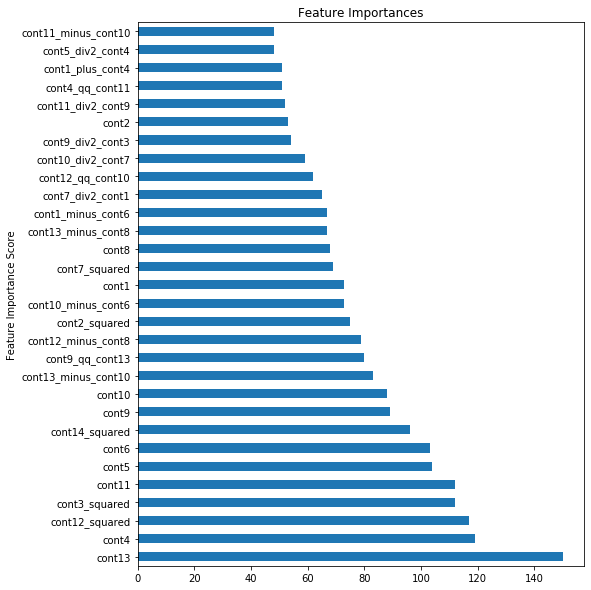

In [10]:
# output the feature importance of the baseline model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, model)

In [11]:
feat_imp

,predictor,fi_score
0,cont13,150
1,cont4,119
2,cont12_squared,117
3,cont3_squared,112
4,cont11,112
5,cont5,104
6,cont6,103
7,cont14_squared,96
8,cont9,89
9,cont10,88


In [12]:
# tune lightgbm model
colsample_bytree_list = [0.7, 0.75, 0.8, 0.85, 0.9]
subsample_list = [0.7, 0.75, 0.8, 0.85, 0.9]

for colsample in colsample_bytree_list:
    for subsample in subsample_list:
        model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=50, 
            max_depth=-1, 
            random_state=314, 
            silent=True,  
            n_jobs=4, 
            n_estimators=60,
            colsample_bytree=colsample,
            subsample=subsample,
            learning_rate=0.1)

    description = "".join(['Colsample ', str(colsample), '; Subsample ',  str(subsample)])
    df = model_check(model, "Step 1 - ColSample, Subsample", description)
    print("Finished checking the model: ", description)
    result_df = pd.concat([result_df, df])

Accuracy of the Regressor on the training set, fold 0: 0.1106
Accuracy of the Regressor on the validation set, fold 0: 0.0766
Accuracy of the Regressor on the hide-out set, fold 0: 0.0763
RMSE of the Regressor on the hideout set, fold 0: 0.7025
Accuracy of the Regressor on the training set, fold 1: 0.1109
Accuracy of the Regressor on the validation set, fold 1: 0.0764
Accuracy of the Regressor on the hide-out set, fold 1: 0.0759
RMSE of the Regressor on the hideout set, fold 1: 0.7027
Accuracy of the Regressor on the training set, fold 2: 0.1095
Accuracy of the Regressor on the validation set, fold 2: 0.0825
Accuracy of the Regressor on the hide-out set, fold 2: 0.0768
RMSE of the Regressor on the hideout set, fold 2: 0.7023
Accuracy of the Regressor on the training set, fold 3: 0.1107
Accuracy of the Regressor on the validation set, fold 3: 0.0757
Accuracy of the Regressor on the hide-out set, fold 3: 0.0765
RMSE of the Regressor on the hideout set, fold 3: 0.7024
Accuracy of the Regr

In [13]:
result_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                          'model_name',	'train_score',	'validation_score',
                         	'test_score',	'test_std',	'test_rmse','fit_time',	'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,model_name,train_score,validation_score,test_score,test_std,test_rmse,fit_time,description
0,Initial model,0.111380,0.077540,0.076360,0.000631,0.702480,0 days 00:00:03.334196600,Initial baseline
5,"Step 1 - ColSample, Subsample",0.111380,0.077540,0.076360,0.000631,0.702480,0 days 00:00:03.489993200,Colsample 0.9; Subsample 0.9
1,"Step 1 - ColSample, Subsample",0.110440,0.077840,0.076300,0.000367,0.702500,0 days 00:00:02.815393800,Colsample 0.7; Subsample 0.9
3,"Step 1 - ColSample, Subsample",0.111040,0.078080,0.076180,0.000390,0.702540,0 days 00:00:03.772401600,Colsample 0.8; Subsample 0.9
2,"Step 1 - ColSample, Subsample",0.110600,0.077800,0.075940,0.000321,0.702660,0 days 00:00:03.187000600,Colsample 0.75; Subsample 0.9
4,"Step 1 - ColSample, Subsample",0.111140,0.078020,0.075940,0.000313,0.702660,0 days 00:00:03.598997800,Colsample 0.85; Subsample 0.9


In [14]:
num_leaves_list = [10,15,20,25,30,40,50,60,70,80,90,100,200, 300, 400, 500, 600, 1000]
for num in num_leaves_list:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=num, 
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=60,
            colsample_bytree=0.9,
            subsample=0.9,
            learning_rate=0.1)

    description = "".join(['NumLeaves ', str(num)])
    df = model_check(model, "Step 2 - NumLeaves", description)
    print("Finished checking the model: ", description)
    result_df = pd.concat([result_df, df])

Accuracy of the Regressor on the training set, fold 0: 0.0657
Accuracy of the Regressor on the validation set, fold 0: 0.0582
Accuracy of the Regressor on the hide-out set, fold 0: 0.0582
RMSE of the Regressor on the hideout set, fold 0: 0.7094
Accuracy of the Regressor on the training set, fold 1: 0.0650
Accuracy of the Regressor on the validation set, fold 1: 0.0577
Accuracy of the Regressor on the hide-out set, fold 1: 0.0577
RMSE of the Regressor on the hideout set, fold 1: 0.7095
Accuracy of the Regressor on the training set, fold 2: 0.0640
Accuracy of the Regressor on the validation set, fold 2: 0.0616
Accuracy of the Regressor on the hide-out set, fold 2: 0.0580
RMSE of the Regressor on the hideout set, fold 2: 0.7094
Accuracy of the Regressor on the training set, fold 3: 0.0643
Accuracy of the Regressor on the validation set, fold 3: 0.0576
Accuracy of the Regressor on the hide-out set, fold 3: 0.0575
RMSE of the Regressor on the hideout set, fold 3: 0.7096
Accuracy of the Regr

Accuracy of the Regressor on the hide-out set, fold 2: 0.0767
RMSE of the Regressor on the hideout set, fold 2: 0.7023
Accuracy of the Regressor on the training set, fold 3: 0.1116
Accuracy of the Regressor on the validation set, fold 3: 0.0758
Accuracy of the Regressor on the hide-out set, fold 3: 0.0763
RMSE of the Regressor on the hideout set, fold 3: 0.7025
Accuracy of the Regressor on the training set, fold 4: 0.1115
Accuracy of the Regressor on the validation set, fold 4: 0.0788
Accuracy of the Regressor on the hide-out set, fold 4: 0.0771
RMSE of the Regressor on the hideout set, fold 4: 0.7022
Finished checking the model:  NumLeaves 50
Accuracy of the Regressor on the training set, fold 0: 0.1203
Accuracy of the Regressor on the validation set, fold 0: 0.0785
Accuracy of the Regressor on the hide-out set, fold 0: 0.0768
RMSE of the Regressor on the hideout set, fold 0: 0.7023
Accuracy of the Regressor on the training set, fold 1: 0.1202
Accuracy of the Regressor on the validati

Accuracy of the Regressor on the training set, fold 0: 0.2634
Accuracy of the Regressor on the validation set, fold 0: 0.0797
Accuracy of the Regressor on the hide-out set, fold 0: 0.0766
RMSE of the Regressor on the hideout set, fold 0: 0.7024
Accuracy of the Regressor on the training set, fold 1: 0.2644
Accuracy of the Regressor on the validation set, fold 1: 0.0772
Accuracy of the Regressor on the hide-out set, fold 1: 0.0774
RMSE of the Regressor on the hideout set, fold 1: 0.7021
Accuracy of the Regressor on the training set, fold 2: 0.2613
Accuracy of the Regressor on the validation set, fold 2: 0.0848
Accuracy of the Regressor on the hide-out set, fold 2: 0.0785
RMSE of the Regressor on the hideout set, fold 2: 0.7017
Accuracy of the Regressor on the training set, fold 3: 0.2640
Accuracy of the Regressor on the validation set, fold 3: 0.0790
Accuracy of the Regressor on the hide-out set, fold 3: 0.0773
RMSE of the Regressor on the hideout set, fold 3: 0.7021
Accuracy of the Regr

In [15]:
result_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                          'model_name',	'train_score',	'validation_score',
                         	'test_score',	'test_std',	'test_rmse','fit_time',	'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,model_name,train_score,validation_score,test_score,test_std,test_rmse,fit_time,description
16,Step 2 - NumLeaves,0.141940,0.080880,0.078920,0.000540,0.701520,0 days 00:00:04.312200400,NumLeaves 90
18,Step 2 - NumLeaves,0.210280,0.081240,0.078840,0.000305,0.701560,0 days 00:00:05.436791800,NumLeaves 200
17,Step 2 - NumLeaves,0.149020,0.081060,0.078640,0.000643,0.701620,0 days 00:00:04.387992800,NumLeaves 100
15,Step 2 - NumLeaves,0.134640,0.080260,0.077960,0.000573,0.701880,0 days 00:00:03.762001400,NumLeaves 80
14,Step 2 - NumLeaves,0.127280,0.079760,0.077660,0.000152,0.701980,0 days 00:00:03.904400200,NumLeaves 70
19,Step 2 - NumLeaves,0.263260,0.079840,0.077540,0.000709,0.702040,0 days 00:00:07.190411400,NumLeaves 300
13,Step 2 - NumLeaves,0.119760,0.079360,0.077180,0.000526,0.702140,0 days 00:00:03.488191,NumLeaves 60
0,Initial model,0.111380,0.077540,0.076360,0.000631,0.702480,0 days 00:00:03.334196600,Initial baseline
5,"Step 1 - ColSample, Subsample",0.111380,0.077540,0.076360,0.000631,0.702480,0 days 00:00:03.489993200,Colsample 0.9; Subsample 0.9
12,Step 2 - NumLeaves,0.111380,0.077540,0.076360,0.000631,0.702480,0 days 00:00:03.572801,NumLeaves 50


In [16]:
min_child_samples = [10, 15, 20, 30, 40, 50, 60,70,80,90,100,120,150,170,200]
for num in min_child_samples:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=90, 
            min_child_samples=num, 
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=60,
            colsample_bytree=0.9,
            subsample=0.9,
            learning_rate=0.1)

    description = "".join(['MinChildSamples ', str(num)])
    df = model_check(model, "Step 3 - MinChildSamples", description)
    print("Finished checking the model: ", description)
    result_df = pd.concat([result_df, df])

Accuracy of the Regressor on the training set, fold 0: 0.1424
Accuracy of the Regressor on the validation set, fold 0: 0.0783
Accuracy of the Regressor on the hide-out set, fold 0: 0.0777
RMSE of the Regressor on the hideout set, fold 0: 0.7020
Accuracy of the Regressor on the training set, fold 1: 0.1427
Accuracy of the Regressor on the validation set, fold 1: 0.0791
Accuracy of the Regressor on the hide-out set, fold 1: 0.0779
RMSE of the Regressor on the hideout set, fold 1: 0.7019
Accuracy of the Regressor on the training set, fold 2: 0.1410
Accuracy of the Regressor on the validation set, fold 2: 0.0857
Accuracy of the Regressor on the hide-out set, fold 2: 0.0787
RMSE of the Regressor on the hideout set, fold 2: 0.7016
Accuracy of the Regressor on the training set, fold 3: 0.1430
Accuracy of the Regressor on the validation set, fold 3: 0.0787
Accuracy of the Regressor on the hide-out set, fold 3: 0.0786
RMSE of the Regressor on the hideout set, fold 3: 0.7016
Accuracy of the Regr

Accuracy of the Regressor on the hide-out set, fold 2: 0.0797
RMSE of the Regressor on the hideout set, fold 2: 0.7012
Accuracy of the Regressor on the training set, fold 3: 0.1403
Accuracy of the Regressor on the validation set, fold 3: 0.0799
Accuracy of the Regressor on the hide-out set, fold 3: 0.0791
RMSE of the Regressor on the hideout set, fold 3: 0.7015
Accuracy of the Regressor on the training set, fold 4: 0.1404
Accuracy of the Regressor on the validation set, fold 4: 0.0822
Accuracy of the Regressor on the hide-out set, fold 4: 0.0792
RMSE of the Regressor on the hideout set, fold 4: 0.7014
Finished checking the model:  MinChildSamples 60
Accuracy of the Regressor on the training set, fold 0: 0.1400
Accuracy of the Regressor on the validation set, fold 0: 0.0798
Accuracy of the Regressor on the hide-out set, fold 0: 0.0784
RMSE of the Regressor on the hideout set, fold 0: 0.7017
Accuracy of the Regressor on the training set, fold 1: 0.1401
Accuracy of the Regressor on the va

Accuracy of the Regressor on the training set, fold 0: 0.1380
Accuracy of the Regressor on the validation set, fold 0: 0.0823
Accuracy of the Regressor on the hide-out set, fold 0: 0.0805
RMSE of the Regressor on the hideout set, fold 0: 0.7009
Accuracy of the Regressor on the training set, fold 1: 0.1379
Accuracy of the Regressor on the validation set, fold 1: 0.0817
Accuracy of the Regressor on the hide-out set, fold 1: 0.0802
RMSE of the Regressor on the hideout set, fold 1: 0.7010
Accuracy of the Regressor on the training set, fold 2: 0.1361
Accuracy of the Regressor on the validation set, fold 2: 0.0875
Accuracy of the Regressor on the hide-out set, fold 2: 0.0809
RMSE of the Regressor on the hideout set, fold 2: 0.7007
Accuracy of the Regressor on the training set, fold 3: 0.1378
Accuracy of the Regressor on the validation set, fold 3: 0.0804
Accuracy of the Regressor on the hide-out set, fold 3: 0.0798
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regr

In [17]:
result_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                          'model_name',	'train_score',	'validation_score',
                         	'test_score',	'test_std',	'test_rmse', 'fit_time',	'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,model_name,train_score,validation_score,test_score,test_std,test_rmse,fit_time,description
37,Step 3 - MinChildSamples,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.691393200,MinChildSamples 170
38,Step 3 - MinChildSamples,0.136840,0.082280,0.080220,0.000638,0.701020,0 days 00:00:03.757591600,MinChildSamples 200
36,Step 3 - MinChildSamples,0.137920,0.082320,0.080060,0.000378,0.701060,0 days 00:00:03.676600800,MinChildSamples 150
35,Step 3 - MinChildSamples,0.138460,0.082280,0.080060,0.000493,0.701080,0 days 00:00:03.594601800,MinChildSamples 120
34,Step 3 - MinChildSamples,0.138760,0.082200,0.079540,0.000114,0.701280,0 days 00:00:03.508192,MinChildSamples 100
33,Step 3 - MinChildSamples,0.139200,0.081880,0.079420,0.000466,0.701300,0 days 00:00:04.959193,MinChildSamples 90
32,Step 3 - MinChildSamples,0.139500,0.081520,0.079460,0.000305,0.701300,0 days 00:00:04.180200600,MinChildSamples 80
29,Step 3 - MinChildSamples,0.140500,0.081360,0.079400,0.000696,0.701320,0 days 00:00:04.940593600,MinChildSamples 50
31,Step 3 - MinChildSamples,0.139760,0.081800,0.079300,0.000548,0.701360,0 days 00:00:05.031803400,MinChildSamples 70
27,Step 3 - MinChildSamples,0.141380,0.081140,0.079280,0.000438,0.701360,0 days 00:00:03.969201600,MinChildSamples 30


In [18]:
min_child_weights = [0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
for num in min_child_weights:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=90,
            min_child_samples=170, 
            min_child_weights = num,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=60,
            colsample_bytree=0.9,
            subsample=0.9,
            learning_rate=0.1)

    description = "".join(['MinChildWeight ', str(num)])
    df = model_check(model, "Step 4 - MinChildWeight", description)
    print("Finished checking the model: ", description)
    result_df = pd.concat([result_df, df])

Accuracy of the Regressor on the training set, fold 0: 0.1380
Accuracy of the Regressor on the validation set, fold 0: 0.0823
Accuracy of the Regressor on the hide-out set, fold 0: 0.0805
RMSE of the Regressor on the hideout set, fold 0: 0.7009
Accuracy of the Regressor on the training set, fold 1: 0.1379
Accuracy of the Regressor on the validation set, fold 1: 0.0817
Accuracy of the Regressor on the hide-out set, fold 1: 0.0802
RMSE of the Regressor on the hideout set, fold 1: 0.7010
Accuracy of the Regressor on the training set, fold 2: 0.1361
Accuracy of the Regressor on the validation set, fold 2: 0.0875
Accuracy of the Regressor on the hide-out set, fold 2: 0.0809
RMSE of the Regressor on the hideout set, fold 2: 0.7007
Accuracy of the Regressor on the training set, fold 3: 0.1378
Accuracy of the Regressor on the validation set, fold 3: 0.0804
Accuracy of the Regressor on the hide-out set, fold 3: 0.0798
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regr

Accuracy of the Regressor on the hide-out set, fold 2: 0.0809
RMSE of the Regressor on the hideout set, fold 2: 0.7007
Accuracy of the Regressor on the training set, fold 3: 0.1378
Accuracy of the Regressor on the validation set, fold 3: 0.0804
Accuracy of the Regressor on the hide-out set, fold 3: 0.0798
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regressor on the training set, fold 4: 0.1376
Accuracy of the Regressor on the validation set, fold 4: 0.0836
Accuracy of the Regressor on the hide-out set, fold 4: 0.0807
RMSE of the Regressor on the hideout set, fold 4: 0.7008
Finished checking the model:  MinChildWeight 0.02
Accuracy of the Regressor on the training set, fold 0: 0.1380
Accuracy of the Regressor on the validation set, fold 0: 0.0823
Accuracy of the Regressor on the hide-out set, fold 0: 0.0805
RMSE of the Regressor on the hideout set, fold 0: 0.7009
Accuracy of the Regressor on the training set, fold 1: 0.1379
Accuracy of the Regressor on the v

In [19]:
result_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                          'model_name',	'train_score',	'validation_score',
                         	'test_score',	'test_std',	'test_rmse', 'fit_time',	'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,model_name,train_score,validation_score,test_score,test_std,test_rmse,fit_time,description
49,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.356985600,MinChildWeight 0.5
47,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.831803600,MinChildWeight 0.1
46,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.806601600,MinChildWeight 0.05
45,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.801202200,MinChildWeight 0.02
44,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.983985,MinChildWeight 0.01
43,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.007995800,MinChildWeight 0.005
42,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.112592,MinChildWeight 0.002
41,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.065205200,MinChildWeight 0.001
40,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.112211800,MinChildWeight 0.0005
39,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.299992200,MinChildWeight 0.0001


In [20]:

reg_alphas = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1,2,3,3.5,4,4.5,5]
for num in reg_alphas:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=90,
            min_child_samples=170,
            reg_alpha=num,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=60,
            colsample_bytree=0.9,
            subsample=0.9,
            learning_rate=0.1)

    description = "".join(['RegAlpha ', str(num)])
    df = model_check(model, "Step 5 - RegAlpha", description)
    print("Finished checking the model: ", description)
    result_df = pd.concat([result_df, df])

Accuracy of the Regressor on the training set, fold 0: 0.1380
Accuracy of the Regressor on the validation set, fold 0: 0.0823
Accuracy of the Regressor on the hide-out set, fold 0: 0.0805
RMSE of the Regressor on the hideout set, fold 0: 0.7009
Accuracy of the Regressor on the training set, fold 1: 0.1379
Accuracy of the Regressor on the validation set, fold 1: 0.0817
Accuracy of the Regressor on the hide-out set, fold 1: 0.0802
RMSE of the Regressor on the hideout set, fold 1: 0.7010
Accuracy of the Regressor on the training set, fold 2: 0.1361
Accuracy of the Regressor on the validation set, fold 2: 0.0875
Accuracy of the Regressor on the hide-out set, fold 2: 0.0809
RMSE of the Regressor on the hideout set, fold 2: 0.7007
Accuracy of the Regressor on the training set, fold 3: 0.1378
Accuracy of the Regressor on the validation set, fold 3: 0.0804
Accuracy of the Regressor on the hide-out set, fold 3: 0.0798
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regr

Accuracy of the Regressor on the hide-out set, fold 2: 0.0810
RMSE of the Regressor on the hideout set, fold 2: 0.7007
Accuracy of the Regressor on the training set, fold 3: 0.1377
Accuracy of the Regressor on the validation set, fold 3: 0.0814
Accuracy of the Regressor on the hide-out set, fold 3: 0.0797
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regressor on the training set, fold 4: 0.1374
Accuracy of the Regressor on the validation set, fold 4: 0.0832
Accuracy of the Regressor on the hide-out set, fold 4: 0.0805
RMSE of the Regressor on the hideout set, fold 4: 0.7009
Finished checking the model:  RegAlpha 0.05
Accuracy of the Regressor on the training set, fold 0: 0.1375
Accuracy of the Regressor on the validation set, fold 0: 0.0812
Accuracy of the Regressor on the hide-out set, fold 0: 0.0797
RMSE of the Regressor on the hideout set, fold 0: 0.7012
Accuracy of the Regressor on the training set, fold 1: 0.1379
Accuracy of the Regressor on the validat

Accuracy of the Regressor on the training set, fold 0: 0.1353
Accuracy of the Regressor on the validation set, fold 0: 0.0813
Accuracy of the Regressor on the hide-out set, fold 0: 0.0797
RMSE of the Regressor on the hideout set, fold 0: 0.7012
Accuracy of the Regressor on the training set, fold 1: 0.1364
Accuracy of the Regressor on the validation set, fold 1: 0.0812
Accuracy of the Regressor on the hide-out set, fold 1: 0.0804
RMSE of the Regressor on the hideout set, fold 1: 0.7009
Accuracy of the Regressor on the training set, fold 2: 0.1335
Accuracy of the Regressor on the validation set, fold 2: 0.0879
Accuracy of the Regressor on the hide-out set, fold 2: 0.0802
RMSE of the Regressor on the hideout set, fold 2: 0.7010
Accuracy of the Regressor on the training set, fold 3: 0.1353
Accuracy of the Regressor on the validation set, fold 3: 0.0815
Accuracy of the Regressor on the hide-out set, fold 3: 0.0798
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regr

In [21]:
result_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                          'model_name',	'train_score',	'validation_score',
                         	'test_score',	'test_std',	'test_rmse', 'fit_time',	'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,model_name,train_score,validation_score,test_score,test_std,test_rmse,fit_time,description
49,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.356985600,MinChildWeight 0.5
37,Step 3 - MinChildSamples,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.691393200,MinChildSamples 170
39,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.299992200,MinChildWeight 0.0001
40,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.112211800,MinChildWeight 0.0005
41,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.065205200,MinChildWeight 0.001
42,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.112592,MinChildWeight 0.002
43,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.007995800,MinChildWeight 0.005
44,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.983985,MinChildWeight 0.01
45,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.801202200,MinChildWeight 0.02
46,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.806601600,MinChildWeight 0.05


In [22]:
reg_lambdas = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1,2,3]
for num in reg_lambdas:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=90,
            min_child_samples=170,
            reg_lambda=num,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            n_estimators=60,
            colsample_bytree=0.9,
            subsample=0.9,
            learning_rate=0.1)

    description = "".join(['RegLambda ', str(num)])
    df = model_check(model, "Step 6 - RegLambda", description)
    print("Finished checking the model: ", description)
    result_df = pd.concat([result_df, df])

Accuracy of the Regressor on the training set, fold 0: 0.1380
Accuracy of the Regressor on the validation set, fold 0: 0.0823
Accuracy of the Regressor on the hide-out set, fold 0: 0.0805
RMSE of the Regressor on the hideout set, fold 0: 0.7009
Accuracy of the Regressor on the training set, fold 1: 0.1379
Accuracy of the Regressor on the validation set, fold 1: 0.0817
Accuracy of the Regressor on the hide-out set, fold 1: 0.0802
RMSE of the Regressor on the hideout set, fold 1: 0.7010
Accuracy of the Regressor on the training set, fold 2: 0.1361
Accuracy of the Regressor on the validation set, fold 2: 0.0875
Accuracy of the Regressor on the hide-out set, fold 2: 0.0809
RMSE of the Regressor on the hideout set, fold 2: 0.7007
Accuracy of the Regressor on the training set, fold 3: 0.1378
Accuracy of the Regressor on the validation set, fold 3: 0.0804
Accuracy of the Regressor on the hide-out set, fold 3: 0.0798
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regr

Accuracy of the Regressor on the hide-out set, fold 2: 0.0809
RMSE of the Regressor on the hideout set, fold 2: 0.7007
Accuracy of the Regressor on the training set, fold 3: 0.1377
Accuracy of the Regressor on the validation set, fold 3: 0.0804
Accuracy of the Regressor on the hide-out set, fold 3: 0.0798
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regressor on the training set, fold 4: 0.1370
Accuracy of the Regressor on the validation set, fold 4: 0.0819
Accuracy of the Regressor on the hide-out set, fold 4: 0.0797
RMSE of the Regressor on the hideout set, fold 4: 0.7012
Finished checking the model:  RegLambda 0.05
Accuracy of the Regressor on the training set, fold 0: 0.1380
Accuracy of the Regressor on the validation set, fold 0: 0.0814
Accuracy of the Regressor on the hide-out set, fold 0: 0.0799
RMSE of the Regressor on the hideout set, fold 0: 0.7011
Accuracy of the Regressor on the training set, fold 1: 0.1378
Accuracy of the Regressor on the valida

In [23]:
result_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                          'model_name',	'train_score',	'validation_score',
                         	'test_score',	'test_std',	'test_rmse', 'fit_time',	'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,model_name,train_score,validation_score,test_score,test_std,test_rmse,fit_time,description
39,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.299992200,MinChildWeight 0.0001
37,Step 3 - MinChildSamples,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.691393200,MinChildSamples 170
41,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.065205200,MinChildWeight 0.001
42,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.112592,MinChildWeight 0.002
43,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.007995800,MinChildWeight 0.005
44,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.983985,MinChildWeight 0.01
45,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.801202200,MinChildWeight 0.02
46,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.806601600,MinChildWeight 0.05
47,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.831803600,MinChildWeight 0.1
48,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:03.984793400,MinChildWeight 0.2


In [24]:
# choosing the optimal learning rate

rates = [
       {'rate': 0.1, 'n': 60},
       {'rate': 0.06, 'n': 100},
       {'rate': 0.05, 'n': 120},
       {'rate': 0.02, 'n': 300}, 
       {'rate': 0.01, 'n': 600},
       {'rate': 0.009, 'n': 654},
       {'rate': 0.005, 'n': 1200},
       {'rate': 0.004, 'n': 1300},
       {'rate': 0.002, 'n': 3000},
       {'rate': 0.001, 'n': 6000},           
]

for rate in rates:
    model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=90, 
            min_child_samples=170,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            colsample_bytree=0.9,
            subsample=0.9,
            n_estimators=rate['n'],
            learning_rate=rate['rate'])

    description = "".join(['LR ', str(rate['rate']), '; nrounds=', str(rate['n'])])
    df = model_check(model, "Step 7 - LR", description)
    print("Finished checking the model: ", description)
    result_df = pd.concat([result_df, df])

Accuracy of the Regressor on the training set, fold 0: 0.1380
Accuracy of the Regressor on the validation set, fold 0: 0.0823
Accuracy of the Regressor on the hide-out set, fold 0: 0.0805
RMSE of the Regressor on the hideout set, fold 0: 0.7009
Accuracy of the Regressor on the training set, fold 1: 0.1379
Accuracy of the Regressor on the validation set, fold 1: 0.0817
Accuracy of the Regressor on the hide-out set, fold 1: 0.0802
RMSE of the Regressor on the hideout set, fold 1: 0.7010
Accuracy of the Regressor on the training set, fold 2: 0.1361
Accuracy of the Regressor on the validation set, fold 2: 0.0875
Accuracy of the Regressor on the hide-out set, fold 2: 0.0809
RMSE of the Regressor on the hideout set, fold 2: 0.7007
Accuracy of the Regressor on the training set, fold 3: 0.1378
Accuracy of the Regressor on the validation set, fold 3: 0.0804
Accuracy of the Regressor on the hide-out set, fold 3: 0.0798
RMSE of the Regressor on the hideout set, fold 3: 0.7012
Accuracy of the Regr

Accuracy of the Regressor on the hide-out set, fold 2: 0.0823
RMSE of the Regressor on the hideout set, fold 2: 0.7002
Accuracy of the Regressor on the training set, fold 3: 0.1391
Accuracy of the Regressor on the validation set, fold 3: 0.0828
Accuracy of the Regressor on the hide-out set, fold 3: 0.0823
RMSE of the Regressor on the hideout set, fold 3: 0.7002
Accuracy of the Regressor on the training set, fold 4: 0.1391
Accuracy of the Regressor on the validation set, fold 4: 0.0841
Accuracy of the Regressor on the hide-out set, fold 4: 0.0822
RMSE of the Regressor on the hideout set, fold 4: 0.7003
Finished checking the model:  LR 0.005; nrounds=1200
Accuracy of the Regressor on the training set, fold 0: 0.1303
Accuracy of the Regressor on the validation set, fold 0: 0.0808
Accuracy of the Regressor on the hide-out set, fold 0: 0.0796
RMSE of the Regressor on the hideout set, fold 0: 0.7013
Accuracy of the Regressor on the training set, fold 1: 0.1305
Accuracy of the Regressor on th

In [25]:
result_df.reset_index().sort_values('test_rmse', 
                   ascending=True)[
                        [ 
                          'model_name',	'train_score',	'validation_score',
                         	'test_score',	'test_std',	'test_rmse', 'fit_time',	'description'
                        ]
                              ][:40].style.background_gradient(cmap='Oranges')

,model_name,train_score,validation_score,test_score,test_std,test_rmse,fit_time,description
89,Step 7 - LR,0.138760,0.084220,0.082120,0.000356,0.700300,0 days 00:09:34.879416800,LR 0.001; nrounds=6000
88,Step 7 - LR,0.138740,0.084280,0.082100,0.000367,0.700300,0 days 00:04:46.311067200,LR 0.002; nrounds=3000
84,Step 7 - LR,0.138720,0.084400,0.082040,0.000404,0.700320,0 days 00:00:27.420407,LR 0.01; nrounds=600
86,Step 7 - LR,0.138760,0.084180,0.082060,0.000305,0.700320,0 days 00:01:30.302714200,LR 0.005; nrounds=1200
83,Step 7 - LR,0.138760,0.084160,0.081920,0.000249,0.700360,0 days 00:00:14.209305200,LR 0.02; nrounds=300
85,Step 7 - LR,0.137520,0.084020,0.081720,0.000487,0.700420,0 days 00:00:29.396583200,LR 0.009; nrounds=654
82,Step 7 - LR,0.138320,0.083240,0.081280,0.000455,0.700600,0 days 00:00:06.395201,LR 0.05; nrounds=120
81,Step 7 - LR,0.138120,0.083140,0.081080,0.000602,0.700700,0 days 00:00:06.070996,LR 0.06; nrounds=100
40,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.112211800,MinChildWeight 0.0005
41,Step 4 - MinChildWeight,0.137480,0.083100,0.080420,0.000432,0.700920,0 days 00:00:04.065205200,MinChildWeight 0.001


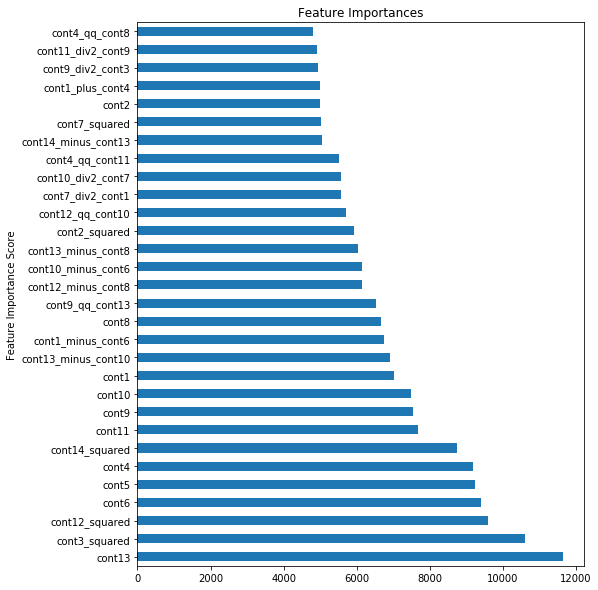

In [26]:
# training and predicting with the best model
best_model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=90, 
            min_child_samples=170,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            colsample_bytree=0.9,
            subsample=0.9,
            n_estimators=3000,
            learning_rate=0.002)

X_train_final = X_train.drop(['target', 'Fold', 'grp'], axis=1, errors='ignore').copy()

best_model.fit(X_train_final, y_train)
# output the feature importance of the best model
feat_imp = print_lightgbm_feature_importance(X_hideout, y_hideout, best_model)


In [27]:
# predicting with the best model on the hideout set
pred_hideout = best_model.predict(X_hideout)
hideout_score = best_model.score(X_hideout, y_hideout.ravel())

print('Score of the Regressor on the hideout set: {:.4f}'.format(hideout_score))

Score of the Regressor on the hideout set: 0.1721


In [28]:
# in scikit-learn >= 0.22.0 
# https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
rmse = mean_squared_error(y_hideout, pred_hideout, squared=False)
print('RMSE of the Regressor on the hideout set: {:.4f}'.format(rmse))



RMSE of the Regressor on the hideout set: 0.6651


# Results

## Submission 1

lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=200, 
            min_child_samples=170,
            reg_alpha=4.5,
            reg_lambda=0.1,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            colsample_bytree=0.7,
            subsample=0.9,
            n_estimators=3000,
            learning_rate=0.002)
            


Best features as selected by FeatureViz: 
relevant_features = ['cont12_qq_cont10', 'cont2_squared', 'cont3_squared', 'cont14_squared', 'cont7_squared', 
                     'cont4_plus_cont3', 'cont4_qq_cont11', 'cont10', 'cont1_minus_cont6', 'cont1_plus_cont4', 
                     'cont3_qq_cont11', 'cont13_minus_cont8', 'cont10_minus_cont6', 'cont7_div2_cont1', 
                     'cont11_minus_cont10', 'cont4_prod_cont2', 'cont10_div2_cont7', 'cont12_squared', 
                     'cont11_div2_cont9', 'cont13_minus_cont10', 'cont14_minus_cont13', 'cont9_qq_cont13', 
                     'cont9_div2_cont3', 'cont5_div2_cont4', 'cont4_qq_cont8', 'cont12_minus_cont8', 
                     'cont9_div2_cont1', 'cont14_plus_cont4', 'cont3_qq_cont2', 'cont1_qq_cont9', 'cont10_div2_cont9', 
                     'cont10_qq_cont9', 'cont12_qq_cont11', 'cont14_div2_cont5', 'cont14_qq_cont8', 'cont6_div2_cont7', 
                     'cont11_div2_cont7', 'cont1_qq_cont10']
            
- 0.701240 RMSE on the 5-fold CV 
- 0.6391 on the local hideout RMSE check
- 0.70748 on the public leaderboard
- Date: Jan 29, 2021


## Submission 2

best_model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            num_leaves=90, 
            min_child_samples=170,
            max_depth=-1, 
            random_state=314, 
            silent=True, 
            n_jobs=4, 
            colsample_bytree=0.9,
            subsample=0.9,
            n_estimators=3000,
            learning_rate=0.002)


Best features as selected in further experiments: 

relevant_features = ['cont12_qq_cont10', 'cont2_squared', 'cont3_squared', 'cont14_squared', 'cont7_squared', 
                     'cont4_plus_cont3', 'cont4_qq_cont11', 'cont10', 'cont1_minus_cont6', 'cont1_plus_cont4', 
                     'cont3_qq_cont11', 'cont13_minus_cont8', 'cont10_minus_cont6', 'cont7_div2_cont1', 
                     'cont4_prod_cont2', 'cont10_div2_cont7', 'cont12_squared', 
                     'cont11_div2_cont9', 'cont13_minus_cont10', 'cont14_minus_cont13', 'cont9_qq_cont13', 
                     'cont9_div2_cont3', 'cont5_div2_cont4', 'cont4_qq_cont8', 'cont12_minus_cont8', 
                     'cont14_plus_cont4',  'cont1_qq_cont9', 
                     'cont10_qq_cont9',   'cont3_qq_cont2',
                     'cont1', 'cont2',  'cont4', 'cont5', 'cont6',  'cont7', 'cont8', 'cont9', 'cont11',
                     'cont12', 'cont13', 'cont14',
                    'cont11_minus_cont10', 'cont1_qq_cont10', 'cont10_div2_cont9', 'cont9_div2_cont1',
                     'cont14_div2_cont5',
                    ]


- 0.700300 RMSE on the 5-fold CV 
- 0.6651 on the local hideout RMSE check
- 0.70571 on the public leaderboard
- Date: Jan 29, 2021

In [29]:
# predicting on the test dataset
pred_test = best_model.predict(df_test)

In [30]:
%%time
#save sumbmission to a file
subm['target'] = pred_test
subm.to_csv('submission.csv', index=False)

Wall time: 462 ms


In [31]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

We are done. That is all, folks!
Finished at  2021-01-29 18:31:13.574720
Elapsed time:  2:10:31.760384
